Tutorial: Multi-material and graded structures
=================
This tutorial demonstrates how to create nanostructures composed of multiple materials or with a graded refractive index.

Load modules
-------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields

from pyGDM2 import core
from pyGDM2 import visu
from pyGDM2 import tools
from pyGDM2 import linear

Gold-Silicon-Gold sandwich structure
--------------------------------------

Instead of defining the dispersion as a single instance of a material class, it is possible to assing a material to every meshpoint of the nanostructure. To do so, we create a list of `material` class instances, each element corresponds to the material of the according element in the *geometry* list.

Here we create 3 blocks (each 10x3x4 meshpoints), the first and the last are gold blocks, and in their center we will stack a silicon block.

In [2]:
## --------------- Setup structure
mesh = 'cube'
step = 20.0

## block 1: gold
geom1 = structures.rect_wire(step, L=10,H=3,W=4, mesh=mesh)
mat1 = len(geom1)*[materials.gold()]

## block 2: silicon. Move Y by width of block1
geom2 = structures.rect_wire(step, L=10,H=3,W=4, mesh=mesh)
geom2.T[1] += 4*step
mat2 = len(geom2)*[materials.silicon()]

## block 3: gold. Move Y by widths of block1 and block2
geom3 = structures.rect_wire(step, L=10,H=3,W=4, mesh=mesh)
geom3.T[1] += 8*step
mat3 = len(geom3)*[materials.gold()]


## put together the two blocks (list of coordinate AND list of materials)
geometry = np.concatenate([geom1, geom2, geom3])
material = mat1 + mat2 + mat3



Now we wrap it in the *struct* object and create the usual *simulation* object with a plane wave illumination.

/home/hans/Documents/programming/work/python/pyGDM2/structures.py:110: UserWarning: Minimum structure Z-value lies below substrate level! Shifting structure bottom to Z=step/2.
  " Shifting structure bottom to Z=step/2.")


timing 500.00nm - inversion: 180.1 ms,repropagation: 2.2ms (1 field configs), total: 182.7 ms


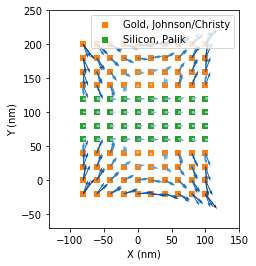

In [3]:
## constant environment
n1, n2 = 1.0, 1.0  
struct = structures.struct(step, geometry, material, n1,n2, structures.get_normalization(mesh))

## incident field
field_generator = fields.planewave
kwargs = dict(theta=0)
wavelengths = [500]
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)


## simulation initialization
sim = core.simulation(struct, efield)


## --------------- run scatter simulation
efield = core.scatter(sim, verbose=True)

## ------------- plot
## plot geometry and real-part of E-field
visu.structure(sim, show=0)
visu.vectorfield_by_fieldindex(sim, 0)

We run the simulation and plot the structure and the electric field vectors (realp part) in the XY plane. Note that the visualization function *visu.struct* recongized the different materials and colors by default the corresponding parts of the structure.

Structure with graded refractive index
--------------------------------------

In a second example, we will create a structure with graded refractive index. To do so, we just loop over all discretization elements and define the according material based on the spatial position of the meshpoint.

In [4]:
## ------------- Setup structure
mesh = 'cube'
step = 20.0
geo = structures.rect_wire(step, L=40, H=5, W=5, mesh=mesh)

## graded material, refindex increasing from 1 to 4 (from left to right)
material = []
value_for_plotting = []
for pos in geo:
    ## grade from 1.0 to 4.0
    n = 1.0 + 3*(pos[0] - geo.T[0].min()) / (geo.T[0].max()-geo.T[0].min())
    material.append(materials.dummy(n))
    value_for_plotting.append(n)              # helper list for plotting of index grading


## constant environment
n1, n2 = 1.0, 1.0  
struct = structures.struct(step, geo, material, n1,n2, structures.get_normalization(mesh))

## incident field
field_generator = fields.planewave        # planwave excitation
kwargs = dict(theta = [90])              # several polarizations
wavelengths = [500]                     # one single wavelength
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

## simulation initialization
sim = core.simulation(struct, efield)

Run simulation and plot
--------------------

timing 500.00nm - inversion: 757.9 ms,repropagation: 11.4ms (1 field configs), total: 769.7 ms


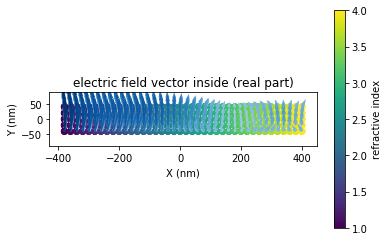

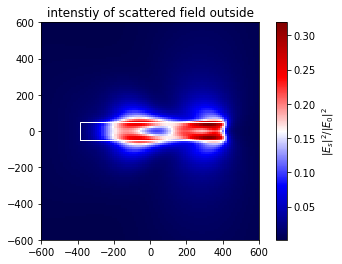

In [5]:
## ------------- run scatter simulation
efield = core.scatter(sim, verbose=True)



## ------------- plot
## plot geometry and real-part of E-field
sc = plt.scatter(geo.T[0], geo.T[1], c=value_for_plotting)
plt.colorbar(sc, label="refractive index")
visu.vectorfield_by_fieldindex(sim, 0, tit='electric field vector inside (real part)')

## nearfield 2 steps above structure
r_probe = tools.generate_NF_map(-600,600,101, -600,600,101, Z0=geo.T[2].max()+2*step)
Es, Et, Bs, Bt = linear.nearfield(sim, 0, r_probe)

visu.structure_contour(sim, color='w', show=0)
visu.vectorfield_color(Es, tit='intenstiy of scattered field outside', show=0)
plt.colorbar(label=r'$|E_s|^2 / |E_0|^2$')
plt.show()

In the grading loop above, we added the refractive index to a second list *value_for_plotting*, which we now used to plot the refractive index of the structure on a color-scale together with the electric field vectors (real part) inside the structure (top plot).

For the bottom plot, we calculated the scattered electric field intensity 2 stepsizes above the structure.